# Scaffold splitting and initial model training using chemprop
> Splitting the now cleaned data using a chemical space aware technique - scaffold splitting. Data is then trained using a directed message passing neural network (D-MPNN).

- toc: false
- badges: true
- comments: true
- categories: [python, bioinformatics, datasets, SMILES, cheminformatics, datamol, RDKit, molecules]
- image: images/play.gif

In [1]:
# import packages

import chemprop
import pandas as pd
import datamol as dm
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
pd.options.mode.chained_assignment = None  # default='warn'


# loading the datasets
MolNet = pd.read_csv("data/MoleculeNet.csv")
B3DB = pd.read_csv("data/B3DB.csv")
b3_molecules = pd.read_csv("data/b3_molecules.csv")

In [2]:
def scaffold_split(df):
    df["mol"] = [Chem.MolFromSmiles(x) for x in df["standard_smiles"]] # generating moles from the standard_smiles column
    df["mol"] = [dm.sanitize_mol(x, sanifix=True, charge_neutral=True) for x in df['mol']] # sanitize mol objects
    df = df.dropna() # dropping NA values
    df["scaffold"] = [MurckoScaffold.GetScaffoldForMol(x) for x in df["mol"]] # generating scaffolds from mol object
    df["mol_scaffold_generic"] = [MurckoScaffold.MakeScaffoldGeneric(x) for x in df["scaffold"]] # generalizing scaffolds
    # convert the generic scaffold mol object back to a SMILES string format
    df["smiles_scaffold_generic"] = [Chem.CanonSmiles(Chem.MolToSmiles(x)) for x in df["mol_scaffold_generic"]]
    
    return df

In [3]:

# results of the scaffold generating function
data_split = scaffold_split(b3_molecules)
data_split.head(1)

,BBB+/BBB-,SMILES,mol,standard_smiles,selfies,inchi,inchikey,scaffold,mol_scaffold_generic,smiles_scaffold_generic
0,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12,"<img data-content=""rdkit/molecule"" src=""data:i...",CC(C)NCC(O)COc1cccc2ccccc12.[Cl-],[C][C][Branch1][C][C][N][C][C][Branch1][C][O][...,InChI=1S/C16H21NO2.ClH/c1-12(2)17-10-14(18)11-...,ZMRUPTIKESYGQW-UHFFFAOYSA-M,"<img data-content=""rdkit/molecule"" src=""data:i...","<img data-content=""rdkit/molecule"" src=""data:i...",C1CCC2CCCCC2C1


In [4]:

# the data prior to processing
MolNet.head(1)

,BBB+/BBB-,SMILES,mol,standard_smiles,selfies,inchi,inchikey
0,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12,"<img data-content=""rdkit/molecule"" src=""data:i...",CC(C)NCC(O)COc1cccc2ccccc12.[Cl-],[C][C][Branch1][C][C][N][C][C][Branch1][C][O][...,InChI=1S/C16H21NO2.ClH/c1-12(2)17-10-14(18)11-...,ZMRUPTIKESYGQW-UHFFFAOYSA-M


In [5]:

# A function to process the data for use with the chemprop library
def chemprop_prep(df, filename):
    df = df.drop(["mol", "SMILES", "selfies", "inchi", "inchikey"], axis=1) # drop all columns except the smiles and target
    df["smiles"] = df["standard_smiles"] # use standard smiles inplace of smiles
    df = df.drop(["standard_smiles"], axis=1) # drop this column now
    df = df[["smiles", "BBB+/BBB-"]] # reorder the columns with smiles first and target second
    df.to_csv('./data/' + filename + '.csv', index=False) # save the file

    return df

In [6]:

# Processing the three different datasets
molnet_chemprop = chemprop_prep(MolNet, 'molnet_chemprop')
B3DB_chemprop = chemprop_prep(B3DB, 'B3DB_chemprep')
b3_mol_chemprop = chemprop_prep(b3_molecules, 'b3_mol_chemprop')

In [7]:

# results of processing
molnet_chemprop.head(1)

,smiles,BBB+/BBB-
0,CC(C)NCC(O)COc1cccc2ccccc12.[Cl-],1


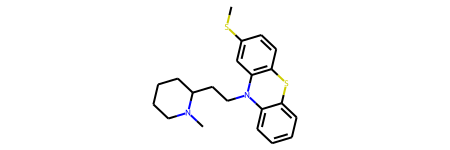

CN1CCCCC1CCN2C3=CC=CC=C3SC4=C2C=C(C=C4)SC


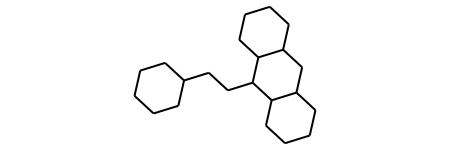

C1CCC(CCC2C3CCCCC3CC3CCCCC32)CC1


In [8]:
# define compound via its SMILES string
smiles = "CN1CCCCC1CCN2C3=CC=CC=C3SC4=C2C=C(C=C4)SC"
# convert SMILES string to RDKit mol object 
mol = Chem.MolFromSmiles(smiles)
# create RDKit mol object corresponding to Bemis-Murcko scaffold of original compound
mol_scaffold = MurckoScaffold.GetScaffoldForMol(mol)
# make the scaffold generic by replacing all atoms with carbons and all bonds with single bonds
mol_scaffold_generic = MurckoScaffold.MakeScaffoldGeneric(mol_scaffold)
# convert the generic scaffold mol object back to a SMILES string format
smiles_scaffold_generic = Chem.CanonSmiles(Chem.MolToSmiles(mol_scaffold_generic))
# display compound and its generic Bemis-Murcko scaffold
display(mol)
print(smiles)
display(mol_scaffold_generic)
print(smiles_scaffold_generic)


In [8]:


arguments = [
    '--data_path', './data/molnet_chemprop.csv',
    '--dataset_type', 'classification',
    '--save_dir', './data/chemprop_checkpoints/',
    '--split_type', 'scaffold_balanced',
 #   '--separate_val_path', './data/chemprop_B3DB.csv',
    '--num_folds', '10',
    '--class_balance',
    '--features_generator', 'rdkit_2d_normalized',
    '--no_features_scaling',
    '--quiet'
    

]

args = chemprop.args.TrainArgs().parse_args(arguments)
mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)

2039it [00:00, 119828.86it/s]
100%|██████████| 2039/2039 [00:00<00:00, 67907.37it/s]
Fold 0
100%|██████████| 30/30 [01:51<00:00,  3.73s/it]
Model 0 best validation auc = 0.926059 on epoch 8
Model 0 test auc = 0.928767
Ensemble test auc = 0.928767
Fold 1
100%|██████████| 30/30 [01:51<00:00,  3.72s/it]
Model 0 best validation auc = 0.886265 on epoch 19
Model 0 test auc = 0.903879
Ensemble test auc = 0.903879
Fold 2
100%|██████████| 30/30 [01:46<00:00,  3.55s/it]
Model 0 best validation auc = 0.917212 on epoch 29
Model 0 test auc = 0.955724
Ensemble test auc = 0.955724
Fold 3
100%|██████████| 30/30 [01:56<00:00,  3.88s/it]
Model 0 best validation auc = 0.886939 on epoch 5
Model 0 test auc = 0.862450
Ensemble test auc = 0.862450
Fold 4
100%|██████████| 30/30 [01:47<00:00,  3.59s/it]
Model 0 best validation auc = 0.897674 on epoch 3
Model 0 test auc = 0.890246
Ensemble test auc = 0.890246
Fold 5
100%|██████████| 30/30 [01:42<00:00,  3.43s/it]
Model 0 best validation auc = 0.977661 on epoch 